In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import math
import os
import random

In [2]:
def add_noise(img,iterations=1):
  
    # Getting the dimensions of the image
    row , col = img.shape

    for i in range(iterations):
      number_of_pixels = random.randint(300 , 10000)
      for i in range(number_of_pixels):
          
          # Pick a random y coordinate
          y_coord=random.randint(0, row - 1)
            
          # Pick a random x coordinate
          x_coord=random.randint(0, col - 1)
            
          # Color that pixel to black
          img[y_coord][x_coord] = 0
          
    return img

In [3]:
filename = "mansion.jpg"
file = os.path.join("./landscape",filename)
field = cv.imread(file,cv.IMREAD_GRAYSCALE)
if field is None : raise Exception("File not found")

In [4]:
from PIL import Image
def show(im):
    if len(im.shape)==3:im = im[:,:,::-1]
    return Image.fromarray(im) 

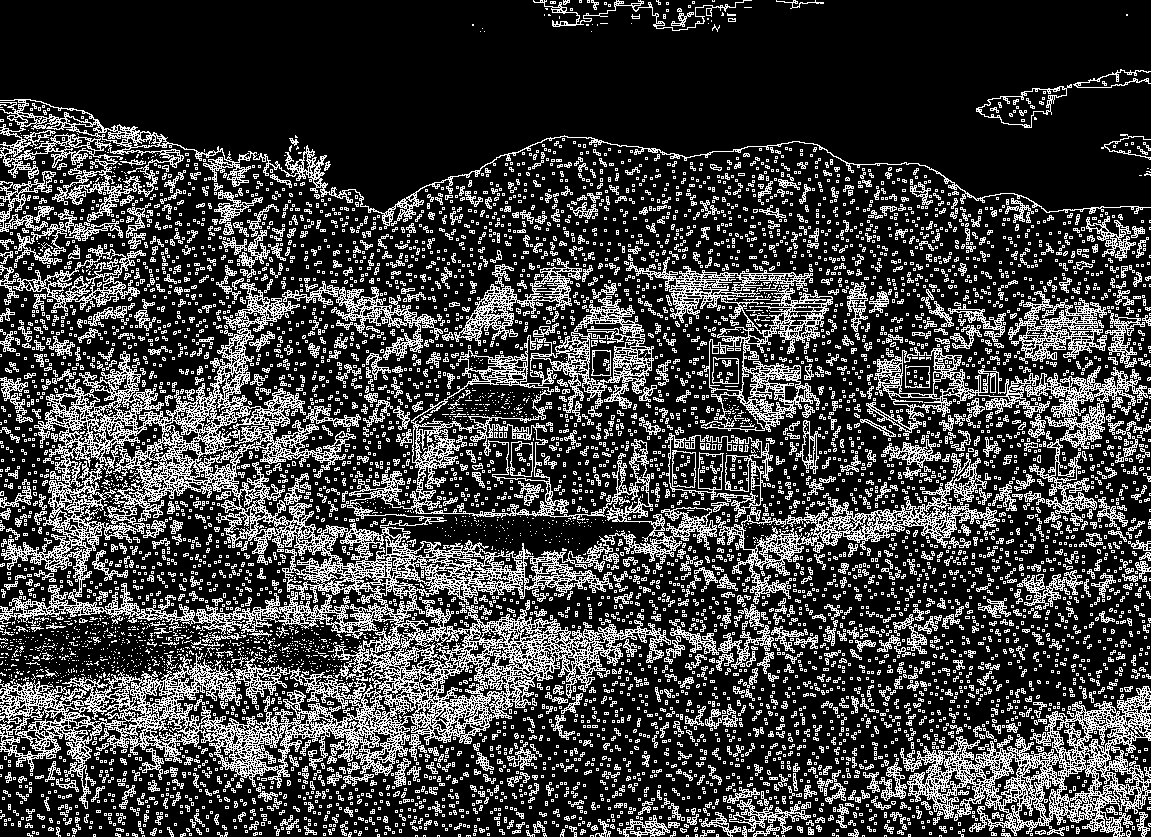

In [5]:
thresh = ~cv.threshold(field, 160, 255, cv.THRESH_BINARY)[1]
thresh = add_noise(thresh, iterations=5)
# thresh = cv.GaussianBlur(thresh, (11, 11), 0)
# thresh = cv.dilate(thresh, None, iterations=1) #- thresh
# thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, (100,100))
thresh = thresh - cv.erode(thresh, None, iterations=1)
show(thresh)

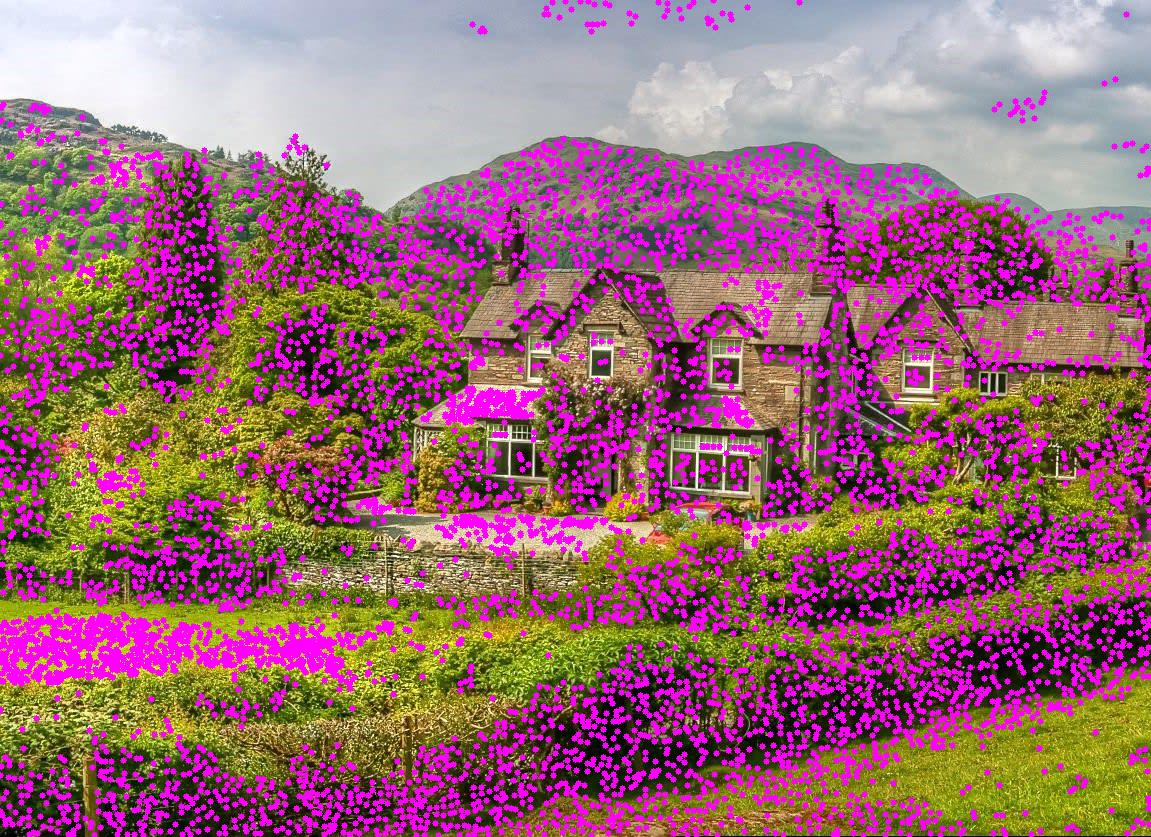

In [6]:
 output = cv.connectedComponentsWithStats(thresh, cv.CV_32S)
(numLabels, labels, stats, centroids) = output
color_field = cv.imread(file)
points = np.zeros(thresh.shape)
centroids = centroids.astype(int)
for center in centroids: cv.circle(color_field,(center[0],center[1]),3,[255,0,255],-1)
#     points[center[1]-2:center[1]+2,center[0]-2:center[0]+2] = 255
show(color_field)

In [7]:
sort = np.sort(centroids,axis=0)
first,last = sort[0],sort[-1]
# radius = math.ceil(math.dist(first,last)/2)
# midpoint = np.asarray([(first[0]+last[0])/2, (first[1]+last[1])/2]).astype(int)
# print(first,midpoint,last)

In [8]:
# color_field = cv.circle(color_field,(midpoint[1],midpoint[0]),radius,[0,0,255],4)
# color_field = cv.circle(color_field,(midpoint[1],midpoint[0]),5,[255,255,0],-1)

In [9]:
# show(color_field)

In [10]:
x = centroids[:,0].reshape(-1,1)
y = centroids[:,1]

In [11]:
import matplotlib.image as mpimg
def show_model(model,img):
    x = centroids[:,0]
    y = centroids[:,1]
    pred = []
    for i in x: pred.append(model.predict(np.asarray([[i]])))
    plt.imshow(img[:,:,::-1])
    plt.plot(x,pred,color='red')
    plt.scatter(x,y,s=2)
    plt.show()
    return pred

In [12]:
import xgboost
from sklearn import tree
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

seed=42
direct_light = cv.imread(file)

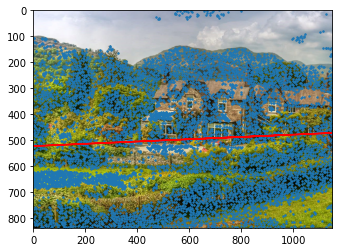

In [13]:
lr = LinearRegression()

#fitting the model
lr.fit(x,y)
lr.score(x,y)
pred = show_model(lr,direct_light)

E:\Anaconda\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


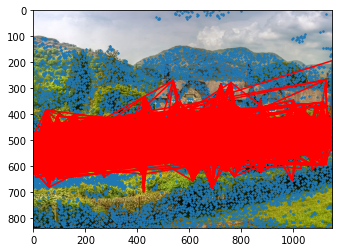

In [14]:
gbr = xgboost.XGBRegressor(random_state=seed)
gbr.fit(x,y)
pred = show_model(gbr,direct_light)

In [15]:
linx,liny = [],[]
for i,p in zip(centroids[:,0],pred): 
    # cv.circle(direct_light,(i,int(p)),3,[255,255,255],-1)
    linx.append(i)
    liny.append(p)
linx = np.asarray(linx).reshape(-1,1)
liny = np.asarray(liny).flatten()

In [16]:
lin = LinearRegression().fit(linx,liny)
linear = lambda x: lin.coef_*x + lin.intercept_
start = (0,int(linear(0)))
end = (direct_light.shape[1],int(linear(direct_light.shape[1])))
line = cv.line(direct_light,start,end,[0,255,255],5)

start = (0,int(gbr.predict(np.asarray([[0]]))))
end = (direct_light.shape[1],int(gbr.predict(np.asarray([[direct_light.shape[1]]]))))
line = cv.line(direct_light,start,end,[0,255,0],4)

start = (0,int(lr.predict([[0]])))
end = (direct_light.shape[1],int(lr.predict([[direct_light.shape[1]]])))
line = cv.line(direct_light,start,end,[255,0,255],2)

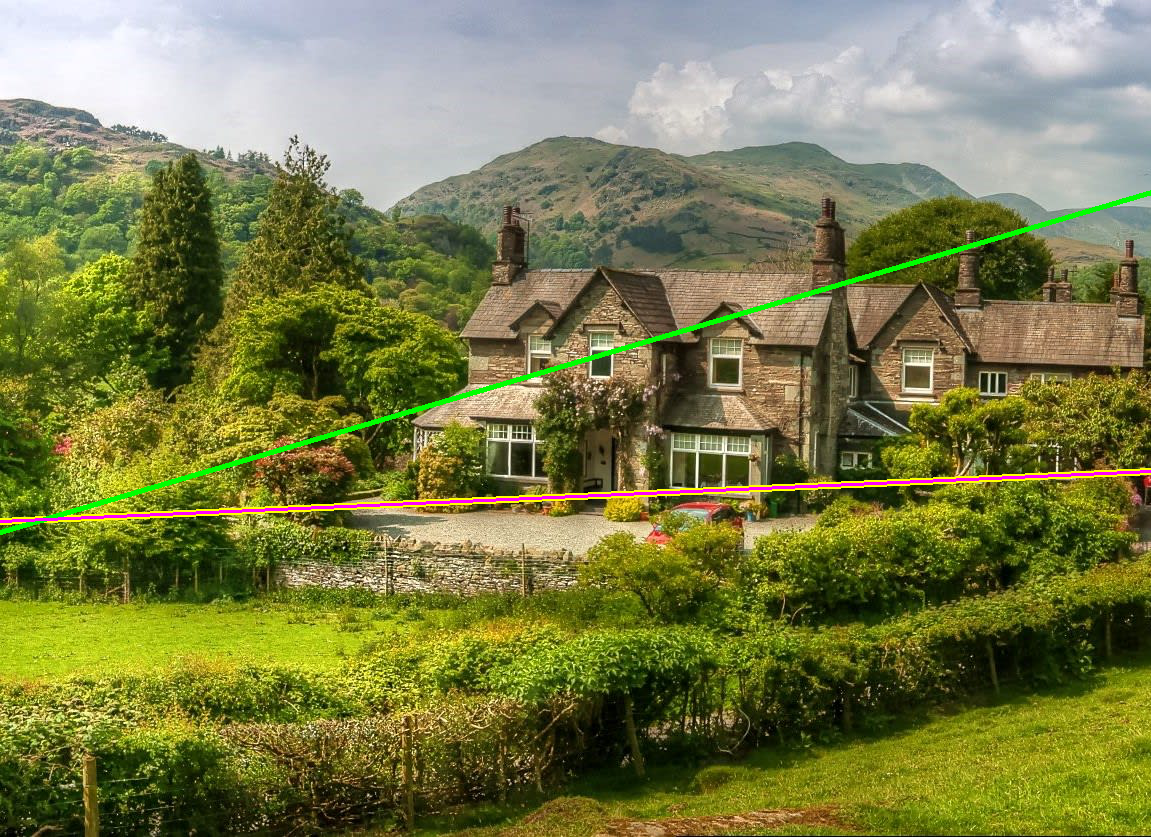

In [17]:
show(direct_light)